如何实现category-level keypoint生成+匹配？
生成：简单的采样即可；
匹配：dino+sd的思路，需要查阅文献。

todo list:
1.mask内单帧匹配;图片尺寸不一样  
2.tap实现point tracking  
3.主动物体的keypoint与被动物体的keypoint之间如何建立联系？(以靠的近的点为原点)  


In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2
import json
import numpy as np
import torch
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from dataset import D415Data#, RopeData

dataloader = D415Data()

In [3]:
# 测试match模块正确性
from match import Matcher
matcher = Matcher()

/home/wts/code/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/wts/code/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/wts/code/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


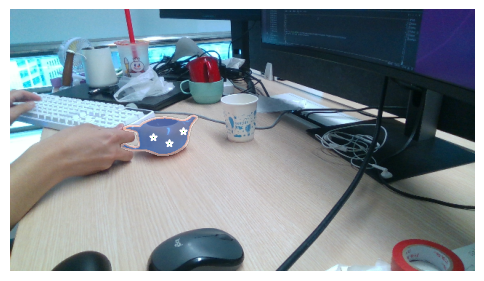

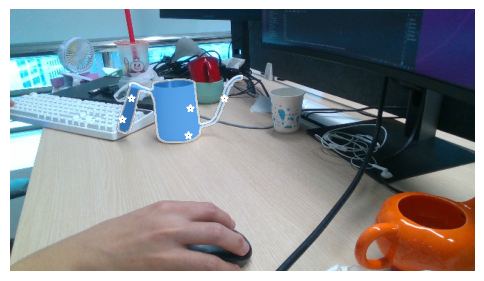

In [4]:
source_scene_id,source_frame_id = 13, 5        
target_scene_id,target_frame_id = 14, 0

# source_scene_id,source_frame_id = 22, 60        # 熊
# target_scene_id,target_frame_id = 42, 100

# # 选两帧数据    电吹风
# source_frame = ropedata.get_frame(scene_id='000064', frame_id='000100',mask_mode='sam2')
# target_frame = ropedata.get_frame(scene_id='000065', frame_id='000160',mask_mode='sam2')

# 选两帧数据  
source_frame = dataloader.get_frame(scene_id=source_scene_id, frame_id=source_frame_id, mask_mode='img')
target_frame = dataloader.get_frame(scene_id=target_scene_id, frame_id=target_frame_id, mask_mode='img')



In [37]:
# match, sim_transform = matcher.match_umeyama(source_frame,target_frame)
# match = matcher.match_estimateAffine3D(source_frame,target_frame)
# match, affine_transform,source_keypoint,target_keypoint = matcher.match_weighted_affine(source_frame,target_frame)
match = matcher.match_nn(source_frame,target_frame)

nn result: 2048


1872


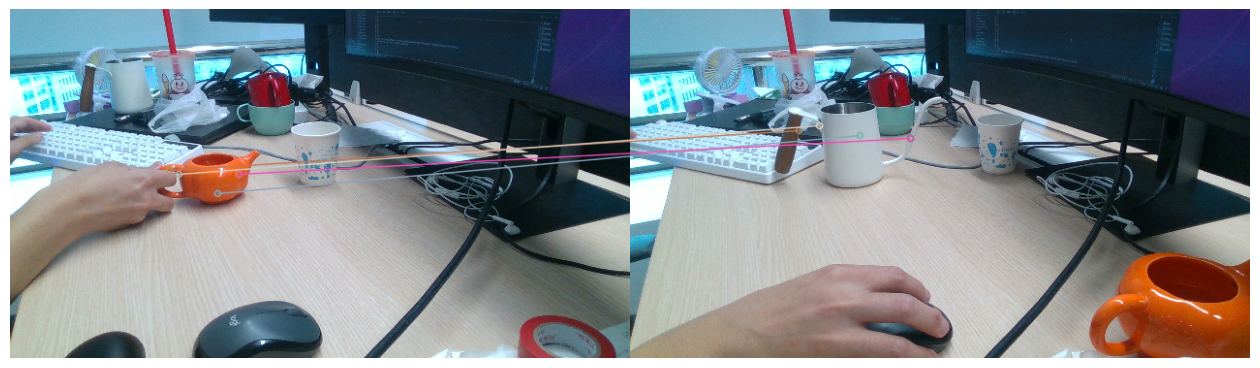

In [124]:
# cv2.imwrite('source.png',cv2.cvtColor(source_frame['rgb'].cpu().numpy(),cv2.COLOR_BGR2RGB))
# cv2.imwrite('target.png',cv2.cvtColor(target_frame['rgb'].cpu().numpy(),cv2.COLOR_BGR2RGB))
import random
def draw_match(source_frame,target_frame,match_2d,draw_num=10):

    def to_keypoints(coords):
        return [cv2.KeyPoint(x=float(coord[0]), y=float(coord[1]), size=1) for coord in coords]

    sampled_indices = random.sample(range(len(match_2d)), draw_num)
    match_2d = match_2d[sampled_indices]

    img_source = source_frame['rgb'].cpu().numpy()
    match2d_source = match_2d[:,:2]

    img_target = target_frame['rgb'].cpu().numpy()
    match2d_target = match_2d[:,2:]


    match_result = cv2.drawMatches(img_source,to_keypoints(match2d_source),img_target,to_keypoints(match2d_target),[cv2.DMatch(i, i, 0) for i in range(len(match_2d))],None)

    return match_result

match_2d = np.loadtxt('vfc_image/result/correct_matches.txt')
print(len(match_2d))
match_result = draw_match(source_frame,target_frame,torch.tensor(match_2d),draw_num=4)
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8)) 
plt.imshow(match_result)
plt.axis('off')  # 隐藏坐标轴
plt.show()

/tmp/ipykernel_3422448/4171522116.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  match_result = matcher.draw_match(source_frame,target_frame,torch.tensor(match),draw_num=4)


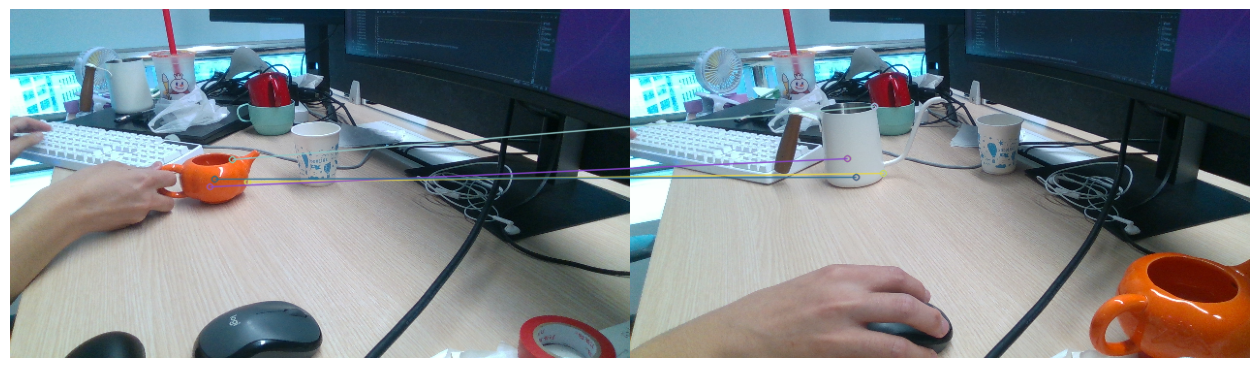

In [117]:
match_result = matcher.draw_match(source_frame,target_frame,torch.tensor(match),draw_num=4)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8)) 
plt.imshow(match_result)
plt.axis('off')  # 隐藏坐标轴
plt.show()

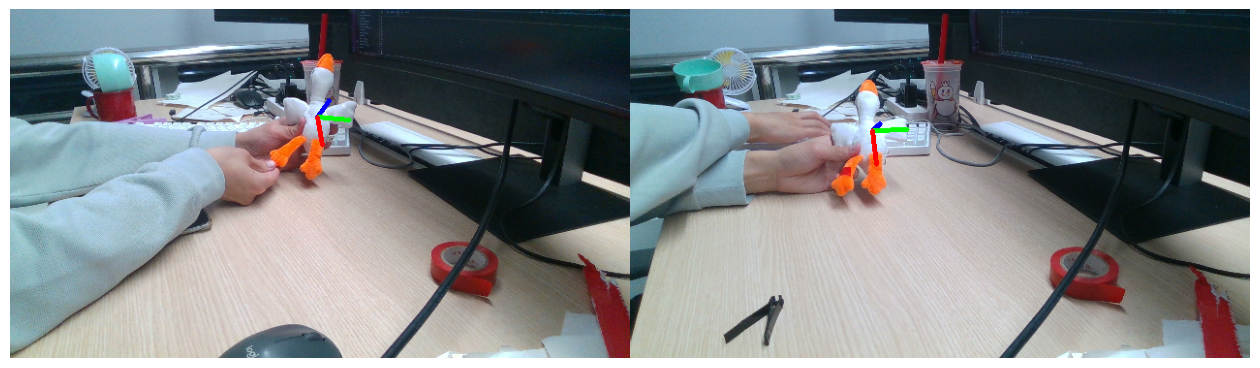

nn result: 2048


: 

In [ ]:
source_init_obj2cam = np.eye(4)
source_init_obj2cam[:3,:3] = np.linalg.inv([[  0.3535534, -0.6123725,  0.7071068],
   [0.9267767,  0.1268265, -0.3535534],
   [0.1268265,  0.7803301,  0.6123725 ] ])   # 随便旋转一个角度
source_init_obj2cam[:3,3] = source_keypoint

transform_result,target_init_obj2cam = matcher.draw_coordinate_transfer(source_frame,target_frame,affine_transform,source_init_obj2cam=source_init_obj2cam)

plt.figure(figsize=(16, 8)) 
plt.imshow(transform_result)
plt.axis('off')  # 隐藏坐标轴
plt.show()

matcher.show_open3d(matcher.match_nn(source_frame,target_frame),affine_transform,source_init_obj2cam=source_init_obj2cam)

In [25]:
from point_tracker import PointTracker,show_video
tracker = PointTracker('cotracker')     # cotracker or spatracker
source_seq = dataloader.get_sequence(scene_id=source_scene_id,start_id=source_frame_id,length=10) #
pose_obj2cam_list = tracker.track_pose(source_seq,source_init_obj2cam,grid_size=160)    # 只用了第一帧的mask
tracker.show_objspace(source_seq,pose_obj2cam_list)
show_video('./tmp_image/video.mp4')

/home/wts/code/coi/segmentanything2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:607.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/wts/code/coi/segmentanything2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/wts/code/coi/segmentanything2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:609.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/wts/code/coi/segmentanything2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to all be of dtype: 

mask video saved to ./test_data/000005/mask.mp4
best weighted inlier ratio: 0.9808075753992864
inlier ratio: 0.9565217391304348
best_scale: [1. 1. 1.]
best weighted inlier ratio: 1.0
inlier ratio: 0.9565217391304348
best_scale: [1. 1. 1.]
best weighted inlier ratio: 0.985479604277706
inlier ratio: 0.8695652173913043
best_scale: [1. 1. 1.]
estimate error,continue


/home/wts/code/coi/umeyama_ransac.py:270: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum()


estimate error,continue
estimate error,continue
best weighted inlier ratio: 0.8765693226996142
inlier ratio: 0.8260869565217391
best_scale: [1. 1. 1.]
estimate error,continue
estimate error,continue
estimate error,continue
best weighted inlier ratio: 0.9801064491669799
inlier ratio: 0.8405797101449275
best_scale: [1. 1. 1.]
estimate error,continue
best weighted inlier ratio: 0.9699396751323903
inlier ratio: 0.8115942028985508
best_scale: [1. 1. 1.]
estimate error,continue
estimate error,continue
estimate error,continue
best weighted inlier ratio: 0.9609396723913103
inlier ratio: 0.7681159420289855
best_scale: [1. 1. 1.]
estimate error,continue
estimate error,continue
estimate error,continue
estimate error,continue
estimate error,continue
estimate error,continue
estimate error,continue
best weighted inlier ratio: 0.9426646747241088
inlier ratio: 0.7391304347826086
best_scale: [1. 1. 1.]
estimate error,continue
estimate error,continue
estimate error,continue


best weighted inlier ratio: 0.900132923745602
inlier ratio: 0.5797101449275363
best_scale: [1. 1. 1.]
Video saved to ./tmp_image/video.mp4


[swscaler @ 0x611fe80] Warning: data is not aligned! This can lead to a speed loss


In [26]:
# pose align visualization
# 用source的所有depth和target的第一帧depth可视化
# todo:color
from utils import transform_pointcloud

point_source, point_source_rgb = source_frame['depth_point'], source_frame['rgb_pointwise']
point_target, point_target_rgb = target_frame['depth_point'], target_frame['rgb_pointwise']

point_source_objspace = transform_pointcloud(point_source, np.linalg.inv(source_init_obj2cam))
point_target_objspace = transform_pointcloud(point_target, np.linalg.inv(target_init_obj2cam))



point_source_list,point_source_rgb_list = [], []
point_target_list,point_target_rgb_list = [], []
for i, obj2cam in enumerate(pose_obj2cam_list):

    # point_source_current = transform_pointcloud(point_source_objspace,obj2cam)
    # point_source_list.append(point_source_current)
    point_source_current,_,point_source_rgb_current = matcher.feature_extracter.extract(source_seq[i])
    point_source_list.append(point_source_current.cpu().numpy())
    point_source_rgb_list.append(point_source_rgb_current.cpu().numpy())

    point_target_current = transform_pointcloud(point_target_objspace,obj2cam)
    point_target_list.append(point_target_current)
    point_target_rgb_list.append(point_target_rgb)

point_source_list = np.stack(point_source_list)
point_target_list = np.stack(point_target_list)
point_source_rgb_list = np.stack(point_source_rgb_list)
point_target_rgb_list = np.stack(point_target_rgb_list)

points = np.concatenate([point_source_list,point_target_list],axis=1)    # t,n+n,3
cube_length = np.std(points) # 用3sigma方差来可视化吧
point_center = points.mean(axis=(0,1))
color = np.concatenate([point_source_rgb_list,point_target_rgb_list],axis=1)

import plotly.graph_objects as go
# 创建图形对象
fig = go.Figure()

# 添加初始数据点
fig.add_trace(
    go.Scatter3d(
        x=points[0,:,0],
        y=points[0,:,1],
        z=points[0,:,2],
        mode='markers',
        marker=dict(size=4,
                    color=color[0],
                    opacity=0.6)
    )
)

# 更新数据并生成动画
frames = []
for i in range(len(pose_obj2cam_list)):

    frame = go.Frame(
        data=[
            go.Scatter3d(
                x=points[i,:,0],
                y=points[i,:,1],
                z=points[i,:,2],
                mode='markers',
                marker=dict(size=4,
                            color=color[i],
                           opacity=0.6)
            )
        ],
        name=f'frame{i}'
    )
    frames.append(frame)

fig.frames = frames

# 设置布局
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[point_center[0]-cube_length/2, point_center[0]+cube_length/2]),
        yaxis=dict(range=[point_center[1]-cube_length/2, point_center[1]+cube_length/2]),
        zaxis=dict(range=[point_center[2]-cube_length/2, point_center[2]+cube_length/2]),
        aspectmode='cube'
    ),
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": True}, "fromcurrent": True}],
                    "label": "Play",
                    "method": "animate",
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top",
        }
    ],
    width = 800,
    height = 800
)

# 显示图形
fig.show()

KeyError: 'depth_point'

[array([-0.00690568, -0.00072337,  0.43381119]),
 array([0.20438928, 0.2105716 , 0.64510616])]